# Environments

Environments allow DAGs to easily switch configuration parameters. These happens for three reasons primarily:

### 1. Allow team members to use the same DAG definition but run in isolated environments

If a DAG is developed by more than one person, you don't want others to accidentally write your files or tables. Ideally, each member should have a completely isolated environment (e.g. users write to their own `/data/{{user}}` folder in the shared server and `{{user}}` schema in the database), but if this is not possible for data scale reasons, there could be overlapping environments.

### 2. Let multiple runs from the same pipeline co-exist

It is a good practice to always have a working version of your code, this is usually done by using a VCS such as git by keeping working code in the `master` branch. Say you finished building your DAG from the `master` banch and now you want to work on a new feature in a `dev` branch, if you switch branches and start making code changes, calling `dag.build()` will overwrite your results, to prevent this from happening you could have one copy for each branch, this way you can work on `dev` and always have a working up-to-date pipeline run for the code stored in `master`.

### 3. Switch between production and development environments


An environment can be started either by passing a dictionary or a path to a YAML file, `Env` also implements a rendering logic where placeholders are resolved, this allows a single DAG definition to switch configuration automatically. Let's implement use case (1) to allow team members have their own environments

In [1]:
from pathlib import Path
import tempfile

import pandas as pd

from ploomber import DAG
from ploomber import Env, with_env
from ploomber.tasks import PythonCallable
from ploomber.products import File

In [2]:
env = Env.start({'path': {'data': '/data/{{user}}'}, 'db': {'uri': 'DB_URI', 'schema': '{{user.lower()}}'}})
print(env)
Env.end()

{'path': {'data': PosixPath('/data/Edu')}, 'db': {'uri': 'DB_URI', 'schema': 'edu'}}


## Integrating Env and DAG

In the previous example, we started and ended and Env manually, to automatically manage the Env lifecycle, the "factory" pattern is introduced.

### Factory pattern

The factory pattern (do not confuse with the pattern in [OOP](https://en.wikipedia.org/wiki/Factory_method_pattern) is simply to have functions return DAG instances:

In [3]:
def make():
    """Simplest factory possible
    """
    return DAG()

Using the factory pattern makes easy to restrict an Env's life to the body of the function using the `@with_env` decorator.

In [4]:
@with_env({'path': {'data': '/data/{{user}}'}})
def make(env):
    """Simplest factory possible
    """
    print('Env is:', env)
    return DAG()

dag = make()

Env is: {'path': {'data': PosixPath('/data/Edu')}}


By coding DAGs this way we can have a single DAG definition whose configuration is automatically resolved at declaration time (inside the function), hence, if someone else calls this function, their environment will be resolved to their corresponding data folder.

Note that we called `make()` without arguments, that's because the decorator injects the environment automatically.

## Using the `{{git}}` placeholder

In [5]:
@with_env({'module': 'ploomber', 'path': {'data': '/data/{{user}}/{{git}}'}})
def make(env):
    """Simplest factory possible
    """
    print('Env is:', env)
    return DAG()

dag = make()

Env is: {'module': 'ploomber', 'path': {'data': PosixPath('/data/Edu/dev')}}


## Env from a YAML file

automatic file finding

name,Ran?,Elapsed (s),Percentage
white,True,0.885998,52.1989
red,True,0.562347,33.1309
all,True,0.249006,14.6703


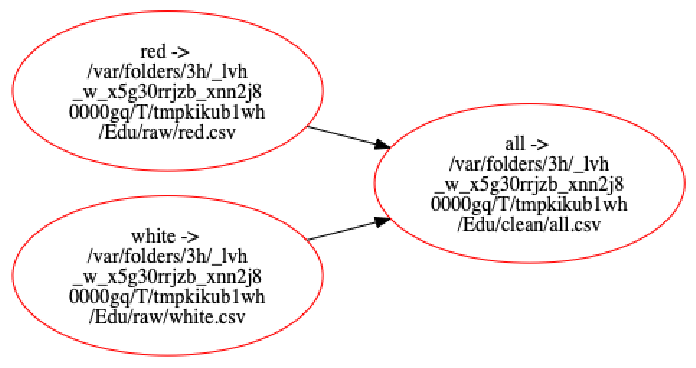

In [20]:
"""
Using environments
==================

Using ploomber.Env to isolate pipeline execution between team members
"""

tmp_dir = Path(tempfile.mkdtemp())

# NOTE: we need this to make sphinx-gallery happy
Env.end()

###############################################################################
# Env can be used to centralize configuration parameters that can be switched
# between users or servers - this configuration ensures that the output
# location is automatically determined (by using the {{user}} placeholder)
# to each user. See ploomber.Env documentation for more details
env = Env.start({'path': {
    'raw': str(tmp_dir / '{{user}}' / 'raw'),
    'clean': str(tmp_dir / '{{user}}' / 'clean')
    }
})


env.path.raw.mkdir(parents=True)
env.path.clean.mkdir(parents=True)

dag = DAG(name='my pipeline')


def get_wine_data(product, filename):
    """Get red wine data
    """
    url = ('http://archive.ics.uci.edu/ml/machine-learning-databases/'
           f'wine-quality/{filename}')
    df = pd.read_csv(url,
                     sep=';',
                     index_col=False)
    # producg is a File type so you have to cast it to a str
    df.to_csv(str(product))


def concat_data(upstream, product):
    """Concatenate red and white wine data
    """
    red = pd.read_csv(str(upstream['red']))
    white = pd.read_csv(str(upstream['white']))
    df = pd.concat([red, white])
    df.to_csv(str(product))


red_task = PythonCallable(get_wine_data,
                          product=File(env.path.raw / 'red.csv'),
                          dag=dag,
                          name='red',
                          params={'filename': 'winequality-red.csv'})

white_task = PythonCallable(get_wine_data,
                            product=File(env.path.raw / 'white.csv'),
                            dag=dag,
                            name='white',
                            params={'filename': 'winequality-white.csv'})

concat_task = PythonCallable(concat_data,
                             product=File(env.path.clean / 'all.csv'),
                             dag=dag, name='all')


red_task >> concat_task
white_task >> concat_task


dag.plot(output='matplotlib')

dag.build()



In [ ]:

what goes here, what does not go here...

In [ ]:
only one env at at ime, explain why